# DeepAR on laptime dataset

laptime dataset
<eventid, carids, laptime (totalcars x totallaps)>

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets


In [2]:
import pickle
with open('laptime-2018.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    laptime_data = pickle.load(f, encoding='latin1')

In [3]:
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}

In [4]:
print(f"events: {events}")

events: ['Phoenix', 'Indy500', 'Texas', 'Iowa', 'Pocono', 'Gateway']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [5]:
laptime_data[2][2].astype(np.float32)

array([[42.3679, 41.0984, 41.0943, ..., 41.5412, 41.3549, 41.7541],
       [43.295 , 41.2297, 41.2107, ...,  0.    ,  0.    ,  0.    ],
       [45.5445, 41.6044, 41.5238, ..., 42.0267, 42.0092, 41.9617],
       ...,
       [45.0093, 45.0862, 42.926 , ..., 42.0984, 41.6441, 41.7593],
       [44.9733, 43.1084, 42.004 , ..., 42.098 , 41.9995, 41.8993],
       [43.7392, 41.1911, 41.799 , ..., 42.2737, 41.967 , 41.8751]],
      dtype=float32)

In [6]:
from gluonts.dataset.common import ListDataset
prediction_length = 50
freq = "1H"
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

train_set = []
test_set = []
#_data: eventid, carids, laptime array
for _data in laptime_data:
    _train = [{'target': x.astype(np.float32), 'start': start} 
            for x in _data[2][:, :-prediction_length]]
    _test = [{'target': x.astype(np.float32), 'start': start} 
            for x in _data[2]]
    train_set.extend(_train)
    test_set.extend(_test)
    



In [7]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(train_set, freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(test_set, freq=freq)

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

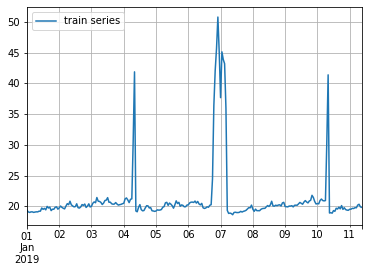

In [8]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

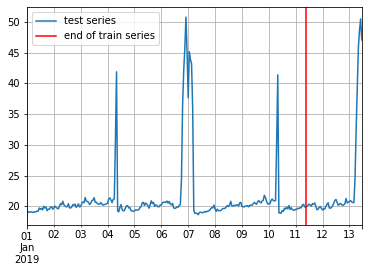

In [9]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [10]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 50
Recommended prediction horizon: 50
Frequency of the time series: 1H


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

INFO:root:Using GPU


In [12]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=100,
    #use_feat_static_cat=True,
    #cardinality=[
    #    feat_static_cat.cardinality
    #    for feat_static_cat in dataset.metadata.feat_static_cat
    #],
    freq=freq,
    trainer=Trainer(ctx="gpu", 
                    epochs=100, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=64
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [13]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 64/64 [00:16<00:00,  3.95it/s, avg_epoch_loss=3.38]
INFO:root:Epoch[0] Elapsed time 16.197 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=3.378015
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.07it/s, avg_epoch_loss=2.61]
INFO:root:Epoch[1] Elapsed time 12.636 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=2.606390
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.02it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[2] Elapsed time 12.744 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=2.344826
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.04it/s, avg_epoch_loss=2.19]
INFO:root:Epoch[3] Elapsed time 12.706 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2.194165
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.09it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.06it/s, avg_epoch_loss=1.24]
INFO:root:Epoch[37] Elapsed time 12.641 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1.241484
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  5.07it/s, avg_epoch_loss=1.36]
INFO:root:Epoch[38] Elapsed time 12.636 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1.356067
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 64/64 [00:13<00:00,  4.91it/s, avg_epoch_loss=1.29]
INFO:root:Epoch[39] Elapsed time 13.039 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1.289091
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 64/64 [00:13<00:00,  4.89it/s, avg_epoch_loss=1.33]
INFO:root:Epoch[40] Elapsed time 13.082 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=1.333625
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 64/64 [00:13<00:00,  4.87it/s, avg_epoch_loss=1.22]
INFO:roo

100%|██████████| 64/64 [00:12<00:00,  4.93it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[74] Elapsed time 12.976 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=1.081991
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 64/64 [00:13<00:00,  4.92it/s, avg_epoch_loss=1.04]
INFO:root:Epoch[75] Elapsed time 13.015 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.041715
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 64/64 [00:13<00:00,  4.91it/s, avg_epoch_loss=0.982]
INFO:root:Epoch[76] Elapsed time 13.035 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.981973
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 64/64 [00:12<00:00,  4.94it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[77] Elapsed time 12.950 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.161485
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 64/64 [00:13<00:00,  4.87it/s, avg_epoch_loss=1.03]
INFO:root:Epoch[78] Elapsed time 13.132 seconds
IN

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [14]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [17]:
# first entry of the time series list
ts_entry = tss[0]

In [18]:
len(ts_entry)

300

In [19]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[-10:]).reshape(-1,)

array([20.7475, 20.6298, 20.6314, 24.5113, 32.4792, 39.4054, 45.9202,
       48.6567, 50.498 , 47.0774], dtype=float32)

In [20]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [21]:
# first 5 values
dataset_test_entry['target'][-10:]

array([20.7475, 20.6298, 20.6314, 24.5113, 32.4792, 39.4054, 45.9202,
       48.6567, 50.498 , 47.0774], dtype=float32)

In [22]:
len(tss[0])

300

In [23]:
forecasts[0].samples.shape

(100, 50)

In [24]:
# Indy500 Car 12 WillPower
ts_entry = tss[52]
ts_entry

,0
2019-01-01 00:00:00,41.923801
2019-01-01 01:00:00,41.035999
2019-01-01 02:00:00,41.333900
2019-01-01 03:00:00,41.091801
2019-01-01 04:00:00,40.790298
...,...
2019-01-09 03:00:00,41.606899
2019-01-09 04:00:00,40.795799
2019-01-09 05:00:00,40.564602
2019-01-09 06:00:00,40.303501


The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [25]:
# first entry of the forecast list
forecast_entry = forecasts[52]

In [26]:
forecast_entry.samples[0,:]

array([72.80842 , 69.332695, 62.04818 , 67.71171 , 67.10379 , 66.27764 ,
       64.141335, 60.934483, 59.286076, 56.983303, 56.20644 , 55.74435 ,
       53.95893 , 53.987076, 53.64106 , 52.75332 , 51.91867 , 52.68782 ,
       52.92183 , 52.65779 , 52.799366, 52.49073 , 52.177876, 51.799263,
       50.559402, 51.404587, 52.88023 , 51.658024, 51.525146, 50.79471 ,
       49.005238, 49.848175, 49.907703, 50.639656, 51.363567, 51.007694,
       51.541912, 51.018326, 50.98353 , 51.372066, 52.73908 , 52.343307,
       53.891075, 52.996723, 52.700813, 52.525417, 55.04868 , 53.367107,
       53.148537, 52.962154], dtype=float32)

In [27]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 50)
Start date of the forecast window: 2019-01-07 06:00:00
Frequency of the time series: 1H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [28]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [76.00856  67.83441  63.543575 58.913208 55.893764 54.085716 53.238514
 50.89628  49.97925  49.72604  48.927567 48.543022 48.142776 47.922173
 47.57655  46.97278  46.56728  46.420177 46.28126  46.14638  45.89657
 45.985714 45.95298  45.53467  45.70061  45.86399  45.896786 46.055702
 45.918602 45.937218 45.8192   45.735703 45.455154 45.175537 45.088226
 44.97646  44.826874 44.93771  44.765884 44.76799  45.421265 46.06271
 46.39361  45.573196 45.123165 45.253555 45.392284 45.429203 45.544273
 45.582985]
0.5-quantile (median) of the future window:
 [76.813995 68.59848  63.073284 58.73838  56.03943  54.65309  53.957222
 53.077095 51.70155  51.689217 51.07521  50.656654 50.151585 49.958664
 49.613926 48.947388 48.57514  48.861813 48.56279  48.36752  48.108803
 48.338882 48.467613 48.15746  48.364826 48.303413 48.48604  48.606926
 48.306488 48.490265 48.69403  48.28106  47.77956  47.849888 47.690823
 47.436718 47.360893 47.98573  47.605385 47.855556 48.32768  48.9

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [29]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

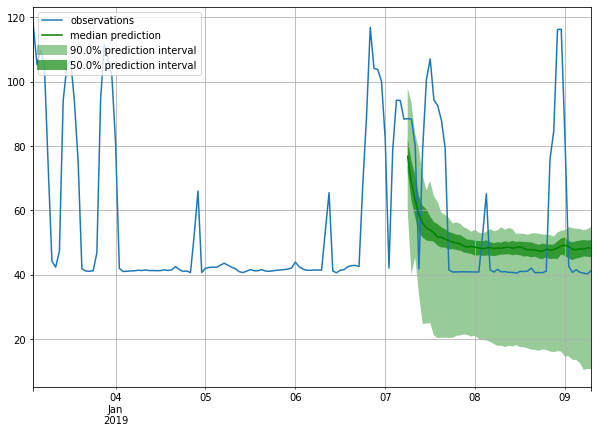

In [30]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [31]:
from gluonts.evaluation import Evaluator

In [32]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 153/153 [00:01<00:00, 136.39it/s]


Aggregate metrics aggregate both across time-steps and across time series.

In [33]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 208.25882206998622,
    "abs_error": 52741.943125247955,
    "abs_target_sum": 199653.72583007812,
    "abs_target_mean": 26.098526252297795,
    "seasonal_error": 8.391928687631866,
    "MASE": 0.9449751246295858,
    "sMAPE": 0.6834115387171916,
    "MSIS": 29.61345820746453,
    "QuantileLoss[0.1]": 32164.61981688702,
    "Coverage[0.1]": 0.3166013071895425,
    "QuantileLoss[0.5]": 52741.942853717366,
    "Coverage[0.5]": 0.6555555555555557,
    "QuantileLoss[0.9]": 52488.89576866955,
    "Coverage[0.9]": 0.8138562091503267,
    "RMSE": 14.431175353032968,
    "NRMSE": 0.552949818450473,
    "ND": 0.2641670868197858,
    "wQuantileLoss[0.1]": 0.1611020264368208,
    "wQuantileLoss[0.5]": 0.2641670854597782,
    "wQuantileLoss[0.9]": 0.26289965564350126,
    "mean_wQuantileLoss": 0.2293895891800334,
    "MAE_Coverage": 0.15276688453159049
}


Individual metrics are aggregated only across time-steps.

In [34]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,85.594541,195.395462,1160.060303,23.201206,3.313522,1.179382,0.138635,36.802547,52.939587,0.00,195.395462,0.28,278.587965,0.74
1,NaN,0.012137,5.683897,0.000000,0.000000,10.103680,0.011251,2.000000,0.031420,0.439886,0.06,5.683897,1.00,2.479465,1.00
2,NaN,92.025225,192.796631,1154.123413,23.082468,3.311920,1.164259,0.132587,38.194831,50.332346,0.00,192.796616,0.46,290.411660,0.74
3,NaN,77.917026,183.765839,1158.099121,23.161982,2.953296,1.244480,0.131091,39.758721,51.463104,0.00,183.765831,0.22,266.978768,0.78
4,NaN,128.029111,293.140045,1112.931152,22.258623,2.855165,2.053401,0.306900,69.138602,177.879180,0.08,293.140047,0.46,344.048212,0.82


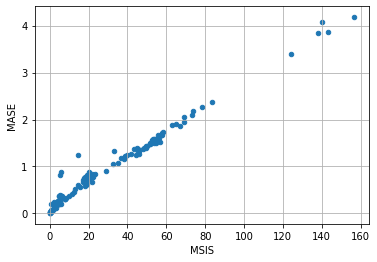

In [35]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()